In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%matplotlib widget

In [3]:
file = 'UMAP'
metadata_file = 'metadata'
identifier = '1650355555'
data = pd.read_csv(f'data/{identifier}/{file}.csv', index_col = 0).fillna(method='ffill').fillna(method='bfill')
metadata = pd.read_csv(f'data/{metadata_file}.tsv', names=['Model output'])
if len(data) > len(metadata):
    if file == 'UMAP' or file == 'PCA':
        data = data[:round(1/3*len(data))].reset_index().drop(columns=['index'])
    elif file == 'TSNE':
        data = data[round(2/3*len(data)):].reset_index().drop(columns=['index'])
    else:
        print('Invalid file name selected')
        halt

data = data[data.columns[:3]]

In [4]:
data

,umap-0,umap-1,umap-2
0,2.900826,-4.124555,-3.546933
1,3.005205,-3.909870,-3.550913
2,3.116504,-3.687666,-3.688222
3,3.452342,-3.008387,-1.571435
4,2.667729,-2.360716,-1.367891
...,...,...,...
4258,2.730554,-4.658438,-2.879191
4259,4.045151,-4.196030,-1.463480
4260,4.031911,-3.809049,-0.917926
4261,3.669370,-3.557314,-0.172480


In [5]:
brightness = 0.55
green_adjust = 9/10
metadata['norm'] = metadata['Model output']/metadata['Model output'].max()
metadata['r'] = brightness
metadata['g'] = green_adjust * brightness
metadata['b'] = metadata['norm']
metadata

,Model output,norm,r,g,b
0,340.008039,0.490979,0.55,0.495,0.490979
1,337.677477,0.487613,0.55,0.495,0.487613
2,374.641128,0.540989,0.55,0.495,0.540989
3,379.400788,0.547863,0.55,0.495,0.547863
4,378.983465,0.547260,0.55,0.495,0.547260
...,...,...,...,...,...
4258,337.213572,0.486943,0.55,0.495,0.486943
4259,333.465954,0.481532,0.55,0.495,0.481532
4260,320.975143,0.463495,0.55,0.495,0.463495
4261,329.382818,0.475636,0.55,0.495,0.475636


In [6]:
new_cols = ['x', 'y', 'z']

In [7]:
data.columns = new_cols

In [8]:
data

,x,y,z
0,2.900826,-4.124555,-3.546933
1,3.005205,-3.909870,-3.550913
2,3.116504,-3.687666,-3.688222
3,3.452342,-3.008387,-1.571435
4,2.667729,-2.360716,-1.367891
...,...,...,...
4258,2.730554,-4.658438,-2.879191
4259,4.045151,-4.196030,-1.463480
4260,4.031911,-3.809049,-0.917926
4261,3.669370,-3.557314,-0.172480


In [9]:
point_cloud = data.values
point_cloud
normals = (point_cloud - [np.mean(point_cloud, axis=0) for _ in range(len(point_cloud))])
colors = (point_cloud + [[0.5, 0.5, 0.5] for _ in range(len(point_cloud))])/1

In [10]:
normals.shape

(4263, 3)

In [11]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(metadata[['r', 'g', 'b']].values)
pcd.normals = o3d.utility.Vector3dVector(normals)

In [12]:
pcd

PointCloud with 4263 points.

In [13]:
# o3d.visualization.draw_geometries([pcd])

In [14]:
algos = ['POISSON', 'ALPHA']
algo = 'alpha'

In [15]:
algo = algo.upper()
if not algo in algos:
    print(f'Algorithm not found. Please, choose one of the following: {algos}')
    halt
else:
    print(f'Selected algorithm: {algo}')

Selected algorithm: ALPHA


In [16]:
if algo == 'ALPHA':
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, .6)
elif algo == 'POISSON':
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, 
                                                                         width=0, scale=1.1, 
                                                                         linear_fit=False)[0]
mesh.compute_triangle_normals()
mesh.compute_vertex_normals()
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = mesh.crop(bbox)

In [17]:
# o3d.visualization.draw_geometries([poisson_mesh])

In [18]:
verts = np.asarray(mesh.vertices)

In [19]:
tris = np.asarray(mesh.triangles)

In [20]:
colors = np.asarray(mesh.vertex_colors)

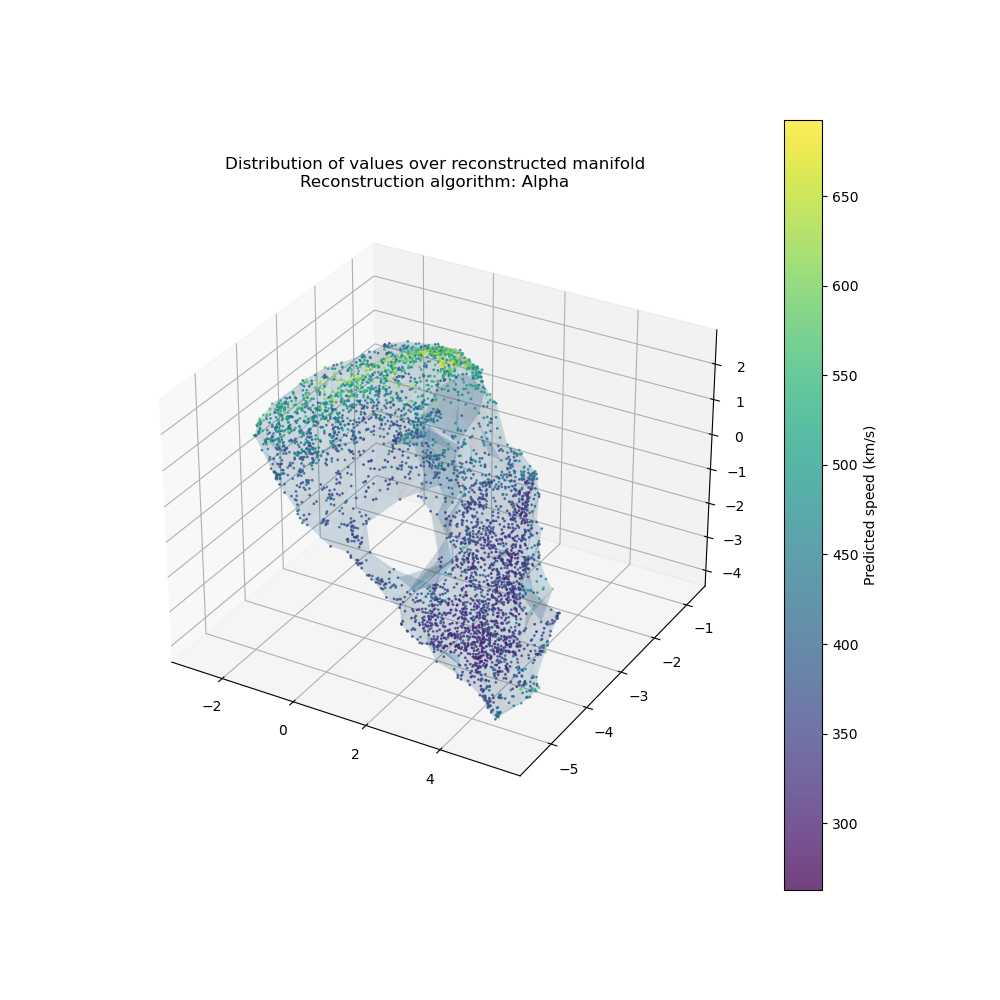

In [21]:
min_val = metadata['Model output'].min()
max_val = metadata['Model output'].max()
vals = metadata['Model output'].values
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plt.title(f'Distribution of values over reconstructed manifold\nReconstruction algorithm: {algo.capitalize()}')
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=tris,
                    shade=True, alpha=.1)
p = ax.scatter(data['x'], data['y'], data['z'], c=metadata['Model output'], alpha=0.75, s=1)
cbar = fig.colorbar(p);
cbar.ax.set_ylabel('Predicted speed (km/s)');